In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [4]:
english_df = pd.read_csv('D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Benchmark output/english_benchmark_output.csv')
tokenizer_split = english_df['tokenizer'].str.extract(r'(?P<grouping>[^_]+(?:_[^_]+)*?)_(?P<type>bpe|unigram|wordpiece)_(?P<vocab_size>\d+)_tokenizer')
english_df = pd.concat([english_df, tokenizer_split[['grouping', 'vocab_size']]], axis=1)
print(english_df)
english_df['vocab_size'] = english_df['vocab_size'].astype(int)

turkish_df = pd.read_csv('D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Benchmark output/turkish_benchmark_output.csv')
tokenizer_split = turkish_df['tokenizer'].str.extract(r'(?P<grouping>[^_]+(?:_[^_]+)*?)_(?P<type>bpe|unigram|wordpiece)_(?P<vocab_size>\d+)_tokenizer')
turkish_df = pd.concat([turkish_df, tokenizer_split[['grouping', 'vocab_size']]], axis=1)
turkish_df['vocab_size'] = turkish_df['vocab_size'].astype(int)

english_df['language'] = 'English'
turkish_df['language'] = 'Turkish'
df = pd.concat([english_df, turkish_df], ignore_index=True)
df = df[['type', 'language', 'grouping', 'vocab_size', 'micro_avg_f1']]

                                            tokenizer       type  fertility  \
0                            base_bpe_16384_tokenizer        BPE     1.5656   
1                             base_bpe_4096_tokenizer        BPE     1.7281   
2                             base_bpe_8192_tokenizer        BPE     1.6280   
3                        base_unigram_16384_tokenizer    Unigram     1.8409   
4                         base_unigram_4096_tokenizer    Unigram     1.9879   
5                         base_unigram_8192_tokenizer    Unigram     1.9101   
6                      base_wordpiece_16384_tokenizer  WordPiece     1.0641   
7                       base_wordpiece_4096_tokenizer  WordPiece     1.2073   
8                       base_wordpiece_8192_tokenizer  WordPiece     1.1138   
9                          lego_bpe_16384_p_tokenizer        BPE     2.4447   
10  lego_bpe_16384_['ADJ', 'ADV', 'INTJ', 'NOUN', ...        BPE     2.4447   
11  lego_bpe_16384_['ADP', 'AUX', 'CCONJ', 'DET', ..

ValueError: cannot convert float NaN to integer

In [ ]:
df

,type,language,grouping,vocab_size,micro_avg_f1
0,BPE,English,base,16384,0.0550
1,BPE,English,base,4096,0.0813
2,BPE,English,base,8192,0.0705
3,Unigram,English,base,16384,0.0194
4,Unigram,English,base,4096,0.0230
5,Unigram,English,base,8192,0.0187
6,WordPiece,English,base,16384,0.0077
7,WordPiece,English,base,4096,0.0171
8,WordPiece,English,base,8192,0.0000
9,BPE,English,lex_gram_oth,16384,0.2064


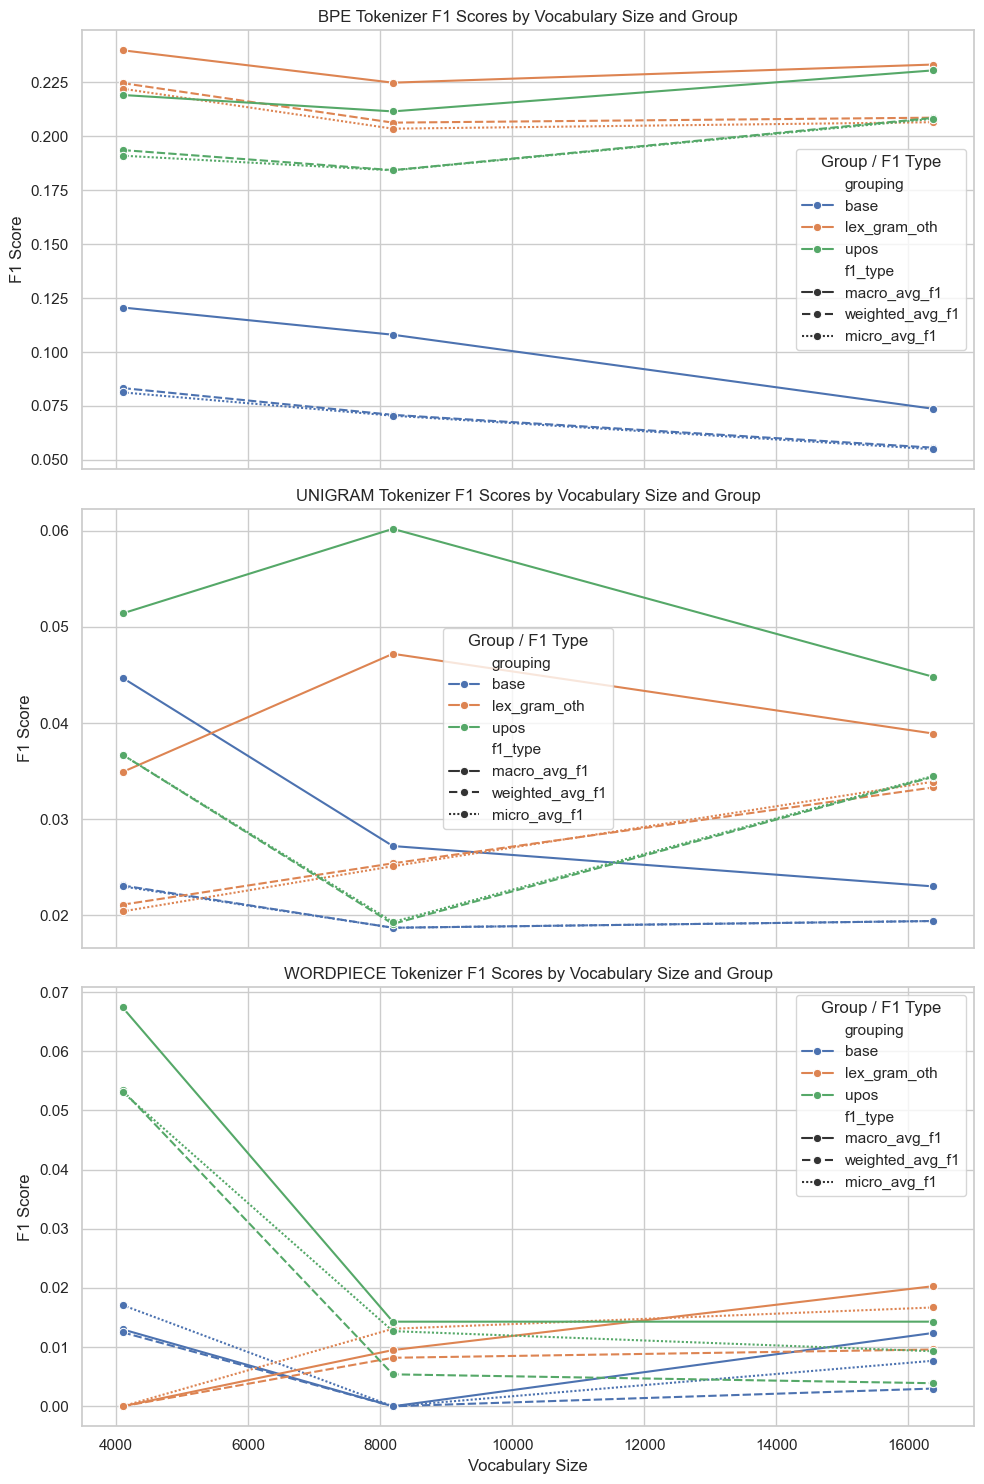

In [ ]:
# Ensure correct types
english_df['vocab_size'] = english_df['vocab_size'].astype(int)

# Melt the F1 score columns into one for easier plotting
f1_metrics = ['macro_avg_f1', 'weighted_avg_f1', 'micro_avg_f1']
df_melted = english_df.melt(
    id_vars=['grouping', 'type', 'vocab_size'],
    value_vars=f1_metrics,
    var_name='f1_type',
    value_name='f1_score'
)

# Plot settings
sns.set(style="whitegrid")
tokenizer_types = english_df['type'].unique()
n_types = len(tokenizer_types)
fig, axes = plt.subplots(n_types, 1, figsize=(10, 5 * n_types), sharex=True)

# Handle the case of a single type
if n_types == 1:
    axes = [axes]

# Plot one subplot per tokenizer type
for ax, tok_type in zip(axes, tokenizer_types):
    subset = df_melted[df_melted['type'] == tok_type]
    
    sns.lineplot(
        data=subset,
        x='vocab_size',
        y='f1_score',
        hue='grouping',
        style='f1_type',
        marker='o',
        ax=ax
    )

    ax.set_title(f'{tok_type.upper()} Tokenizer F1 Scores by Vocabulary Size and Group')
    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Vocabulary Size')
    ax.legend(title='Group / F1 Type')

plt.tight_layout()
plt.show()


In [ ]:
english_df['language'] = 'English'
turkish_df['language'] = 'Turkish'
df = pd.concat([english_df, turkish_df], ignore_index=True)
df = df[['type', 'language', 'grouping', 'vocab_size', 'micro_avg_f1']]

In [ ]:
grouping_pairs = [('upos', 'base'), ('lex_gram_oth', 'base'), ('upos', 'lex_gram_oth')]
diff_df_list = []

for (lang, typ), group in df.groupby(['language', 'type']):
    for grp1, grp2 in grouping_pairs:
        # Pivot to get both F1 scores side by side
        pivot = group[group['grouping'].isin([grp1, grp2])].pivot(
            index='vocab_size', columns='grouping', values='micro_avg_f1'
        )
        if grp1 in pivot.columns and grp2 in pivot.columns:
            diff = pivot[grp1] - pivot[grp2]
            diff_df = diff.reset_index()
            diff_df['type'] = typ
            diff_df['language'] = lang
            diff_df['comparison'] = f"{grp1} - {grp2}"
            diff_df_list.append(diff_df)
diff_df_all = pd.concat(diff_df_list, ignore_index=True)
diff_df_all = diff_df_all.rename(columns={0: 'f1_diff'})
diff_df_all['group'] = (
    diff_df_all['language'] + ' | ' +
    diff_df_all['type']
)

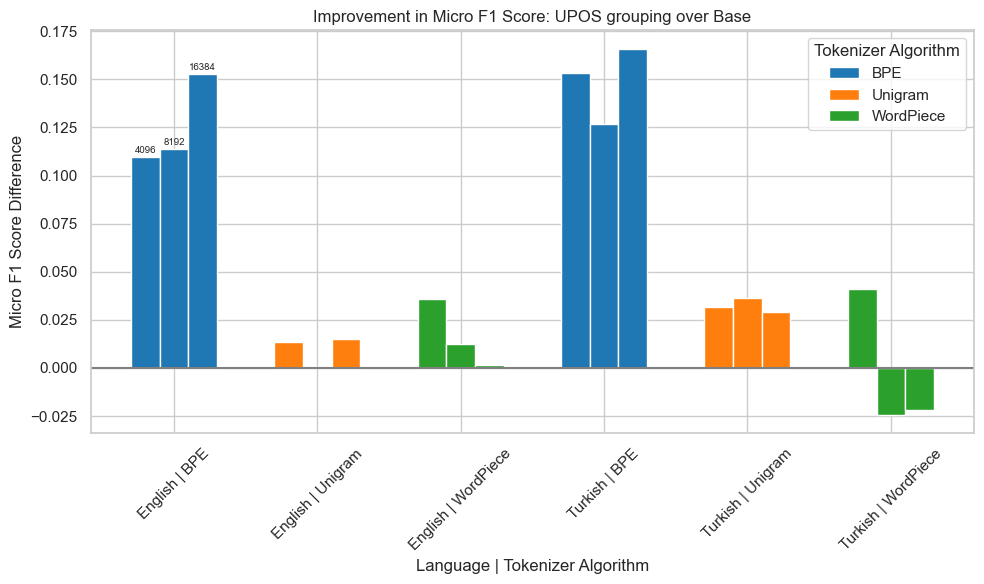

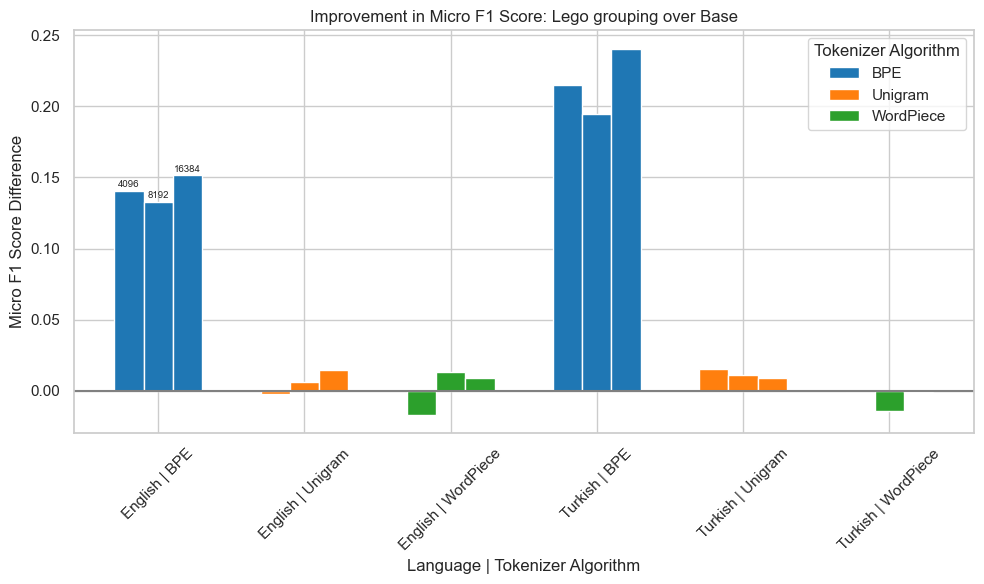

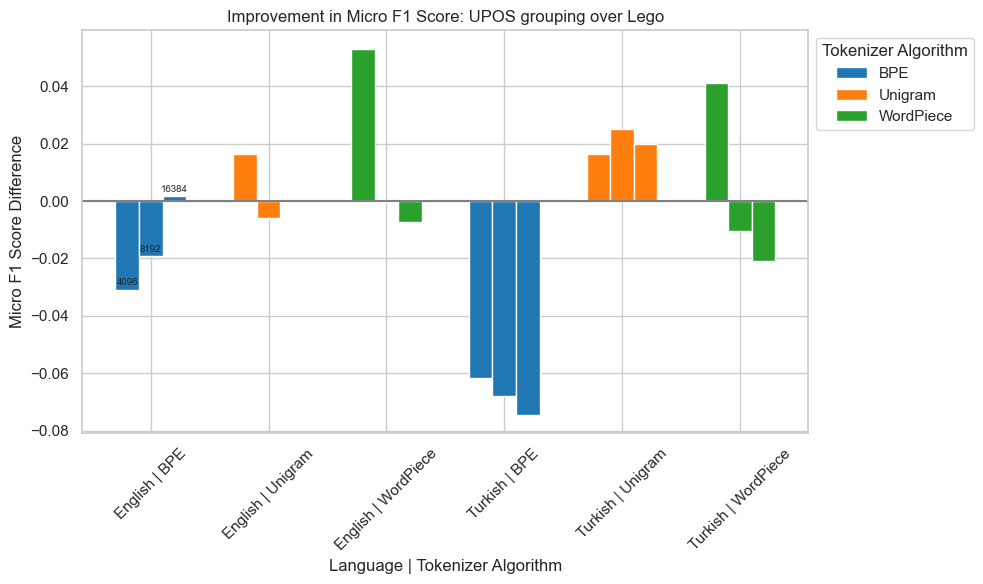

In [ ]:
sns.set(style='whitegrid')

comparisons = diff_df_all['comparison'].unique()
palette = dict(zip(diff_df_all['type'].unique(), sns.color_palette("tab10")))

for comp in comparisons:
    subset = diff_df_all[diff_df_all['comparison'] == comp].copy()
    
    subset['group'] = subset['language'] + ' | ' + subset['type']
    groups = subset['group'].unique()
    vocab_sizes = sorted(subset['vocab_size'].unique())

    bar_width = 0.2
    x_ticks = []
    x_tick_labels = []

    plt.figure(figsize=(10, 6))
    seen_types = set()

    for i, group in enumerate(groups):
        group_data = subset[subset['group'] == group]
        for j, vocab in enumerate(vocab_sizes):
            row = group_data[group_data['vocab_size'] == vocab]
            if row.empty:
                continue
            x = i + j * bar_width - bar_width  # center bars

            typ = row['type'].values[0]
            color = palette[typ]
            label = typ if typ not in seen_types else None
            seen_types.add(typ)

            bar = plt.bar(
                x,
                row['f1_diff'].values[0],
                width=bar_width,
                color=color,
                label=label,
            )

            # Annotate vocab_size above bar
            if i == 0:
                plt.text(
                    x,
                    row['f1_diff'].values[0] + 0.001,  # offset
                    str(vocab),
                    ha='center',
                    va='bottom',
                    fontsize=7
                )

        x_ticks.append(i)
        x_tick_labels.append(group)

    plt.axhline(0, color='gray', linestyle='-', linewidth=1.5)


    first, second = comp.split(' - ')
    pretty_names = {
        'upos': 'UPOS',
        'base': 'Base',
        'lex_gram_oth': 'Lego'
    }
    first = pretty_names.get(first, first)
    second = pretty_names.get(second, second)

    plt.title(f'Improvement in Micro F1 Score: {first} grouping over {second}')
    plt.xlabel('Language | Tokenizer Algorithm')
    plt.ylabel('Micro F1 Score Difference')
    plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=45)
    plt.legend(title='Tokenizer Algorithm', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    filename = comp.replace(" ", "_").replace("|", "").replace("/", "_")
    plt.savefig(f"D:/Dropbox/Bachelorarbeit/Tokenization by Word Tag/Plots/{filename}.pdf", format='pdf')

    plt.show()


In [ ]:
df = english_df[['type', 'grouping', 'vocab_size', 'micro_avg_f1']]
df

,type,grouping,vocab_size,micro_avg_f1
0,BPE,base,16384,0.0550
1,BPE,base,4096,0.0813
2,BPE,base,8192,0.0705
3,Unigram,base,16384,0.0194
4,Unigram,base,4096,0.0230
5,Unigram,base,8192,0.0187
6,WordPiece,base,16384,0.0077
7,WordPiece,base,4096,0.0171
8,WordPiece,base,8192,0.0000
9,BPE,lex_gram_oth,16384,0.2064


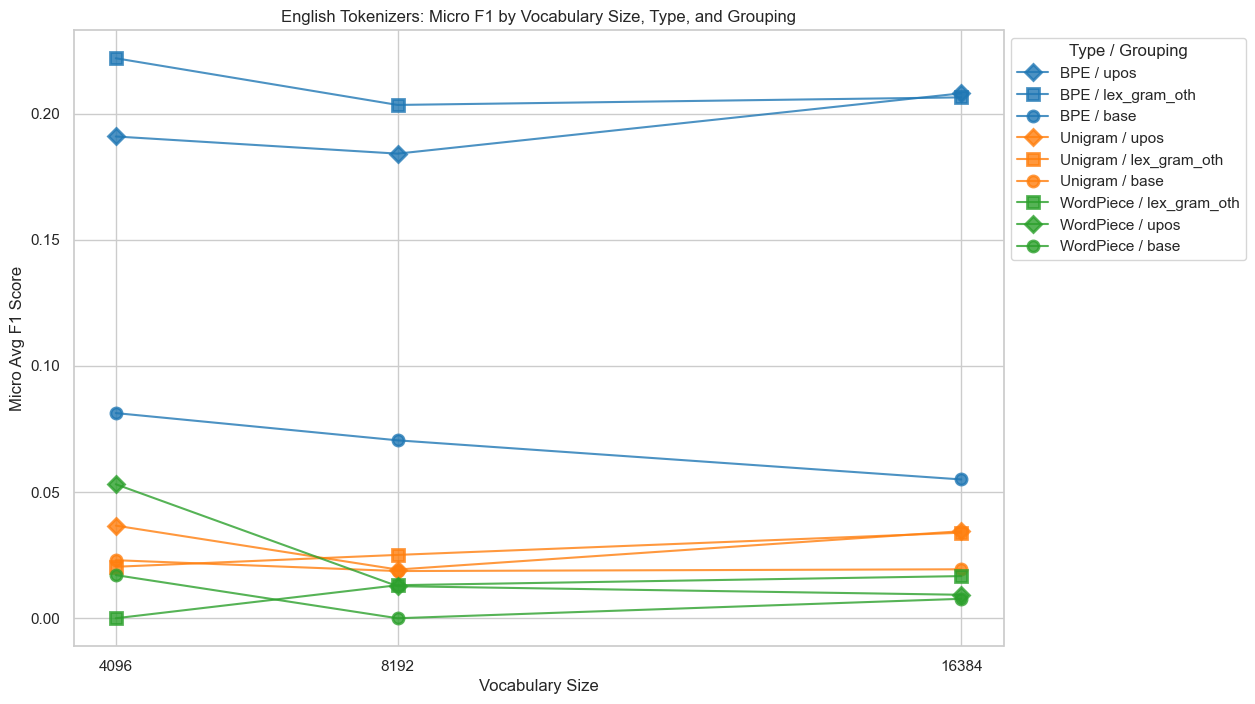

In [ ]:
color_map = dict(zip(df['type'].unique(), sns.color_palette("tab10", n_colors=df['type'].nunique())))
marker_map = dict(zip(df['grouping'].unique(), ['o', 's', 'D', '^', 'v', 'P', '*']))

plt.figure(figsize=(12, 8))
lines_dict = {}

for (typ, grp), group_data in df.groupby(['type', 'grouping']):
    sorted_group = group_data.sort_values('vocab_size')
    line, = plt.plot(
        sorted_group['vocab_size'],
        sorted_group['micro_avg_f1'],
        marker=marker_map[grp],
        color=color_map[typ],
        markersize=8,
        markeredgewidth=2,
        linestyle='-',
        alpha=0.8,
        label=f"{typ} / {grp}"
    )
    lines_dict[(typ, grp)] = line

# Legend for color (type)
legend_elements_type = [
    Line2D([0], [0], marker='o', color='w', label=typ, markerfacecolor=color_map[typ], markersize=8)
    for typ in color_map
]

# Legend for marker (grouping)
legend_elements_grouping = [
    Line2D([0], [0], marker=marker_map[grp], color='k', label=grp, markerfacecolor='gray', markersize=8)
    for grp in marker_map
]

plt.xlabel('Vocabulary Size')
plt.xticks(sorted(df['vocab_size'].unique()))
plt.ylabel('Micro Avg F1 Score')
plt.title('English Tokenizers: Micro F1 by Vocabulary Size, Type, and Grouping')

sort_df = df[df['vocab_size'] == 16384][['type', 'grouping', 'micro_avg_f1']]
sort_df['key'] = list(zip(sort_df['type'], sort_df['grouping']))
sorted_keys  = sort_df.sort_values('micro_avg_f1', ascending=False)['key'].tolist()
sorted_handles = [lines_dict[key] for key in sorted_keys if key in lines_dict]
plt.legend(handles=sorted_handles, title='Type / Grouping', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()